<a href="https://colab.research.google.com/github/alawrence30/Deep-Learning/blob/main/Assignment_02_v1_Experiments_5_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>






<img src="https://github.com/djp840/MSDS_458_Public/blob/master/images/NorthwesternHeader.png?raw=1">

## MSDS458 Research Assignment 02 - Part 1
<div class="alert alert-block alert-success">
    <b>More Technical</b>: Throughout the notebook. This types of boxes provide more technical details and extra references about what you are seeing. They contain helpful tips, but you can safely skip them the first time you run through the code.
</div><br>

The CIFAR-10 dataset (Canadian Institute For Advanced Research) is a collection of images that are commonly used to train machine learning and computer vision algorithms. It is one of the most widely used datasets for machine learning research. The CIFAR-10 dataset contains 60,000 32x32 color images in 10 different classes. The 10 different classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. There are 6,000 images of each class.

<div class="alert alert-block alert-info">
<b>The CIFAR-10 dataset</b><br>
https://www.cs.toronto.edu/~kriz/cifar.html
    </div>

## Imports

In [1]:
import datetime
import time
import numpy as np
import pandas as pd
from packaging import version
from collections import Counter

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical

In [2]:
%matplotlib inline
np.set_printoptions(precision=3, suppress=True)

## Verify TensorFlow Version and Keras Version

In [3]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.9.2


In [4]:
print("Keras version: ", keras.__version__)

Keras version:  2.9.0


## Mount Google Drive to Colab environment

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## EDA Functions

In [6]:
def get_three_classes(x, y):
    def indices_of(class_id):
        indices, _ = np.where(y == float(class_id))
        return indices

    indices = np.concatenate([indices_of(0), indices_of(1), indices_of(2)], axis=0)
    
    x = x[indices]
    y = y[indices]
    
    count = x.shape[0]
    indices = np.random.choice(range(count), count, replace=False)
    
    x = x[indices]
    y = y[indices]
    
    y = tf.keras.utils.to_categorical(y)
    
    return x, y

In [7]:
def show_random_examples(x, y, p):
    indices = np.random.choice(range(x.shape[0]), 10, replace=False)
    
    x = x[indices]
    y = y[indices]
    p = p[indices]
    
    plt.figure(figsize=(10, 5))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(x[i])
        plt.xticks([])
        plt.yticks([])
        col = 'green' if np.argmax(y[i]) == np.argmax(p[i]) else 'red'
        plt.xlabel(class_names_preview[np.argmax(p[i])], color=col)
    plt.show()

## Research Assignment Reporting Functions

In [8]:
def plot_history(history):
  losses = history.history['loss']
  accs = history.history['accuracy']
  val_losses = history.history['val_loss']
  val_accs = history.history['val_accuracy']
  epochs = len(losses)

  plt.figure(figsize=(16, 4))
  for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
  plt.show()

In [9]:
def print_validation_report(y_test, predictions):
    print("Classification Report")
    print(classification_report(y_test, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(y_test, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(y_test, predictions)))) 

In [10]:
def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8,8))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

## Loading cifar10 Dataset

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.<br>

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class.


In [11]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

170498071/170498071 [==============================] - 3s 0us/step


* Tuple of Numpy arrays: (x_train, y_train), (x_test, y_test).
* x_train, x_test: uint8 arrays of color image data with shapes (num_samples, 32, 32).
* y_train, y_test: uint8 arrays of digit labels (integers in range 0-9)

## EDA Training and Test Datasets

* Imported 50000 examples for training and 10000 examples for test 
* Imported 50000 labels for training and 10000 labels for test 

In [12]:
print('train_images:\t{}'.format(x_train.shape))
print('train_labels:\t{}'.format(y_train.shape))
print('test_images:\t\t{}'.format(x_test.shape))
print('test_labels:\t\t{}'.format(y_test.shape))

train_images:	(50000, 32, 32, 3)
train_labels:	(50000, 1)
test_images:		(10000, 32, 32, 3)
test_labels:		(10000, 1)


## Review Labels 

In [13]:
print("First ten labels training dataset:\n {}\n".format(y_train[0:10]))
print("This output the numeric label, need to convert to item description")

First ten labels training dataset:
 [[6]
 [9]
 [9]
 [4]
 [1]
 [1]
 [2]
 [7]
 [8]
 [3]]

This output the numeric label, need to convert to item description


## Plot Subset of Examples

In [14]:
(train_images, train_labels),(test_images, test_labels)= tf.keras.datasets.cifar10.load_data()

In [15]:
x_preview, y_preview = get_three_classes(train_images, train_labels)
x_preview, y_preview = get_three_classes(test_images, test_labels)

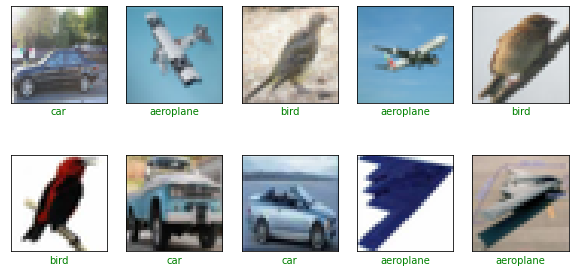

In [16]:
class_names_preview = ['aeroplane', 'car', 'bird']

show_random_examples(x_preview, y_preview, y_preview)

## Preprocessing Data for Model Development

The labels are an array of integers, ranging from 0 to 9. These correspond to the class of clothing the image represents:

|Label  |Class_  |
|-------|--------|
|0|	airplane     |
|1|	automobile   |
|2|	bird         |
|3|	cat          |
|4|	deer         |
|5|	dog          |
|6|	frog         |
|7|	horse        |
|8|	ship         |
|9|	truck        |

In [17]:
class_names = ['airplane'
,'automobile'
,'bird'
,'cat'
,'deer'
,'dog'
,'frog' 
,'horse'
,'ship'
,'truck']

## Create Validation Data Set

In [18]:
x_train_split, x_valid_split, y_train_split, y_valid_split = train_test_split(x_train
                                                                              ,y_train
                                                                              ,test_size=.1
                                                                              ,random_state=42
                                                                              ,shuffle=True)

## Confirm Datasets {Train, Validation, Test}

In [19]:
print(x_train_split.shape, x_valid_split.shape, x_test.shape)

(45000, 32, 32, 3) (5000, 32, 32, 3) (10000, 32, 32, 3)


## Rescale Examples  {Train, Validation, Test}
The images are 28x28 NumPy arrays, with pixel values ranging from 0 to 255
 

1. Each element in each example is a pixel value
2. Pixel values range from 0 to 255
3. 0 = black
4. 255 = white

In [20]:
x_train_norm = x_train_split/255
x_valid_norm = x_valid_split/255
x_test_norm = x_test/255

print(x_train_norm.shape, x_valid_norm.shape, x_test_norm.shape)

(45000, 32, 32, 3) (5000, 32, 32, 3) (10000, 32, 32, 3)


## Create the Model

<img src="https://github.com/djp840/MSDS_458_Public/blob/master/images/CNN_architecture_v4.png?raw=1">


##Experiment 5: Experiment 2 with regularization 
https://www.analyticsvidhya.com/blog/2018/04/fundamentals-deep-learning-regularization-techniques/

In [21]:
from time import perf_counter 
from keras import regularizers
from keras.layers.core import Dropout

#### Model 5.2 

Same as Model 2 with regularization

In [22]:
model_5_2 = Sequential()
model_5_2.add(keras.layers.Flatten(input_shape = [32, 32, 3]))
model_5_2.add(layers.Dense(units = 100, activation = "relu", kernel_regularizer=regularizers.l2(0.01)))
model_5_2.add(layers.Dense(units = 250, activation = "relu", kernel_regularizer=regularizers.l2(0.01)))
model_5_2.add(layers.Dense(units = 150, activation = "relu", kernel_regularizer=regularizers.l2(0.01)))
model_5_2.add(layers.Dense(name = "output_layer", units = 10, activation = "softmax"))

model_5_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 100)               307300    
                                                                 
 dense_1 (Dense)             (None, 250)               25250     
                                                                 
 dense_2 (Dense)             (None, 150)               37650     
                                                                 
 output_layer (Dense)        (None, 10)                1510      
                                                                 
Total params: 371,710
Trainable params: 371,710
Non-trainable params: 0
_________________________________________________________________


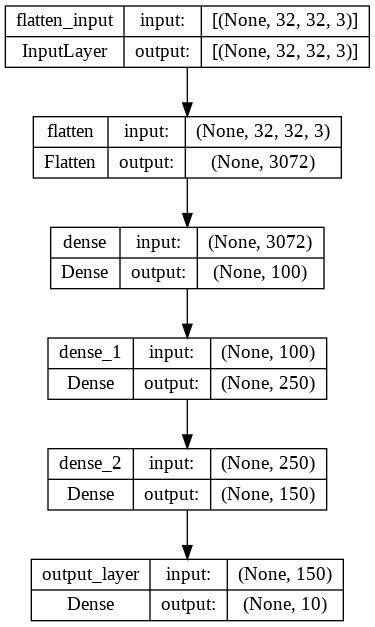

In [23]:
keras.utils.plot_model(model_5_2, "CIFAR_model.png", show_shapes=True) 

In [24]:
## Compile

model_5_2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [25]:
## Train 
time = perf_counter()

history_5_2 = model_5_2.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("DNN_model_5_2.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ]                                                                                                           
                   )

Epoch 1/200
704/704 [==============================] - 6s 4ms/step - loss: 2.5637 - accuracy: 0.2990 - val_loss: 2.0452 - val_accuracy: 0.3126
Epoch 2/200
704/704 [==============================] - 3s 4ms/step - loss: 1.9793 - accuracy: 0.3370 - val_loss: 1.9744 - val_accuracy: 0.3346
Epoch 3/200
704/704 [==============================] - 3s 4ms/step - loss: 1.9254 - accuracy: 0.3510 - val_loss: 1.9415 - val_accuracy: 0.3478
Epoch 4/200
704/704 [==============================] - 2s 3ms/step - loss: 1.9067 - accuracy: 0.3568 - val_loss: 1.9617 - val_accuracy: 0.3384
Epoch 5/200
704/704 [==============================] - 3s 4ms/step - loss: 1.8881 - accuracy: 0.3642 - val_loss: 1.9983 - val_accuracy: 0.3298
Epoch 6/200
704/704 [==============================] - 3s 4ms/step - loss: 1.8848 - accuracy: 0.3637 - val_loss: 1.9063 - val_accuracy: 0.3582
Epoch 7/200
704/704 [==============================] - 3s 5ms/step - loss: 1.8731 - accuracy: 0.3650 - val_loss: 1.8574 - val_accuracy: 0.3712

In [26]:
time_5_2 = perf_counter() - time
print(time_5_2)

30.875752653000006


In [27]:
## Evaluate

model_5_2 = tf.keras.models.load_model("DNN_model_5_2.h5")
print(f"Test acc: {model_5_2.evaluate(x_test_norm, y_test)[1]:.3f}")

313/313 [==============================] - 1s 3ms/step - loss: 1.8209 - accuracy: 0.3880
Test acc: 0.388


#### Model 5.2.1

Same as Model 2 with bais regularization L2

In [33]:
from keras.regularizers import l2

model_5_21 = Sequential()
model_5_21.add(keras.layers.Flatten(input_shape = [32, 32, 3]))
model_5_21.add(layers.Dense(units = 100, activation = "relu", bias_regularizer=l2(0.01)))
model_5_21.add(layers.Dense(units = 250, activation = "relu", bias_regularizer=l2(0.01)))
model_5_21.add(layers.Dense(units = 150, activation = "relu", bias_regularizer=l2(0.01)))
model_5_21.add(layers.Dense(name = "output_layer", units = 10, activation = "softmax"))

model_5_21.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 3072)              0         
                                                                 
 dense_6 (Dense)             (None, 100)               307300    
                                                                 
 dense_7 (Dense)             (None, 250)               25250     
                                                                 
 dense_8 (Dense)             (None, 150)               37650     
                                                                 
 output_layer (Dense)        (None, 10)                1510      
                                                                 
Total params: 371,710
Trainable params: 371,710
Non-trainable params: 0
_________________________________________________________________


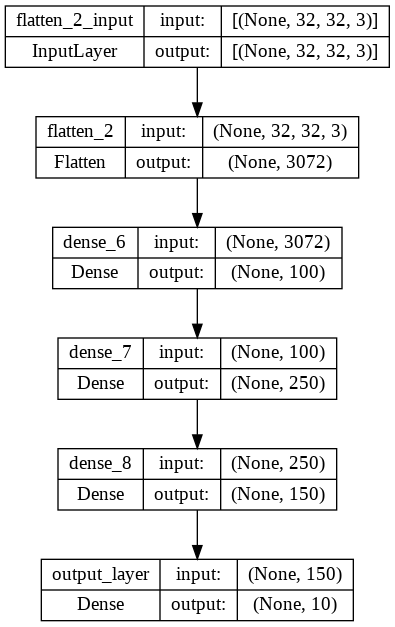

In [34]:
keras.utils.plot_model(model_5_21, "CIFAR_model.png", show_shapes=True) 

In [35]:
## Compile

model_5_21.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [36]:
## Train 
time = perf_counter()

history_5_21 = model_5_21.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("DNN_model_5_21.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ]                                                                                                           
                   )

Epoch 1/200
704/704 [==============================] - 3s 4ms/step - loss: 1.8644 - accuracy: 0.3215 - val_loss: 1.7707 - val_accuracy: 0.3592
Epoch 2/200
704/704 [==============================] - 3s 4ms/step - loss: 1.6984 - accuracy: 0.3923 - val_loss: 1.6687 - val_accuracy: 0.3982
Epoch 3/200
704/704 [==============================] - 2s 4ms/step - loss: 1.6183 - accuracy: 0.4178 - val_loss: 1.5942 - val_accuracy: 0.4216
Epoch 4/200
704/704 [==============================] - 2s 3ms/step - loss: 1.5660 - accuracy: 0.4392 - val_loss: 1.6177 - val_accuracy: 0.4254
Epoch 5/200
704/704 [==============================] - 3s 4ms/step - loss: 1.5216 - accuracy: 0.4537 - val_loss: 1.5670 - val_accuracy: 0.4368
Epoch 6/200
704/704 [==============================] - 3s 4ms/step - loss: 1.4935 - accuracy: 0.4667 - val_loss: 1.5249 - val_accuracy: 0.4502
Epoch 7/200
704/704 [==============================] - 3s 4ms/step - loss: 1.4667 - accuracy: 0.4759 - val_loss: 1.5254 - val_accuracy: 0.4508

In [37]:
time_5_21 = perf_counter() - time
print(time_5_21)

44.452118283000004


In [38]:
## Evaluate

model_5_21 = tf.keras.models.load_model("DNN_model_5_21.h5")
print(f"Test acc: {model_5_21.evaluate(x_test_norm, y_test)[1]:.3f}")

313/313 [==============================] - 1s 3ms/step - loss: 1.4410 - accuracy: 0.4900
Test acc: 0.490


#### Model 5.2.2 - BEST MODEL 2, tied with 5.2.3

Same as Model 5.2.1 with bais regularization L2, updated nodes (550, 300, 250)

In [39]:
from keras.regularizers import l2

model_5_22 = Sequential()
model_5_22.add(keras.layers.Flatten(input_shape = [32, 32, 3]))
model_5_22.add(layers.Dense(units = 550, activation = "relu", bias_regularizer=l2(0.01)))
model_5_22.add(layers.Dense(units = 300, activation = "relu", bias_regularizer=l2(0.01)))
model_5_22.add(layers.Dense(units = 250, activation = "relu", bias_regularizer=l2(0.01)))
model_5_22.add(layers.Dense(name = "output_layer", units = 10, activation = "softmax"))

model_5_22.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 3072)              0         
                                                                 
 dense_9 (Dense)             (None, 550)               1690150   
                                                                 
 dense_10 (Dense)            (None, 300)               165300    
                                                                 
 dense_11 (Dense)            (None, 250)               75250     
                                                                 
 output_layer (Dense)        (None, 10)                2510      
                                                                 
Total params: 1,933,210
Trainable params: 1,933,210
Non-trainable params: 0
_________________________________________________________________


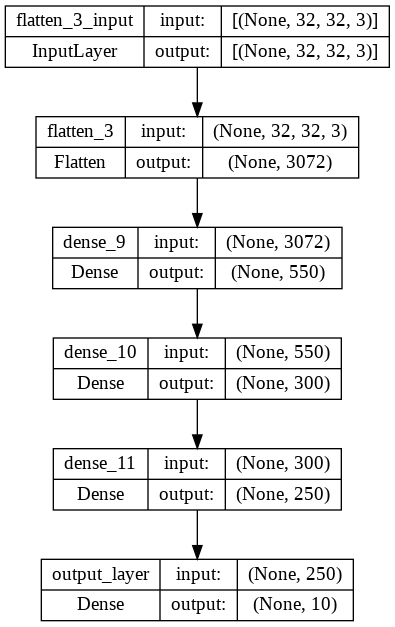

In [40]:
keras.utils.plot_model(model_5_22, "CIFAR_model.png", show_shapes=True) 

In [41]:
## Compile

model_5_22.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [42]:
## Train 
time = perf_counter()

history_5_22 = model_5_22.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("DNN_model_5_22.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ]                                                                                                           
                   )

Epoch 1/200
704/704 [==============================] - 3s 4ms/step - loss: 1.8907 - accuracy: 0.3155 - val_loss: 1.7842 - val_accuracy: 0.3496
Epoch 2/200
704/704 [==============================] - 3s 4ms/step - loss: 1.6902 - accuracy: 0.3935 - val_loss: 1.6733 - val_accuracy: 0.4000
Epoch 3/200
704/704 [==============================] - 3s 4ms/step - loss: 1.6076 - accuracy: 0.4239 - val_loss: 1.6289 - val_accuracy: 0.4178
Epoch 4/200
704/704 [==============================] - 3s 4ms/step - loss: 1.5454 - accuracy: 0.4484 - val_loss: 1.5537 - val_accuracy: 0.4456
Epoch 5/200
704/704 [==============================] - 3s 4ms/step - loss: 1.4907 - accuracy: 0.4684 - val_loss: 1.5570 - val_accuracy: 0.4386
Epoch 6/200
704/704 [==============================] - 3s 4ms/step - loss: 1.4606 - accuracy: 0.4784 - val_loss: 1.5070 - val_accuracy: 0.4640
Epoch 7/200
704/704 [==============================] - 3s 4ms/step - loss: 1.4230 - accuracy: 0.4932 - val_loss: 1.5049 - val_accuracy: 0.4614

In [43]:
time_5_22 = perf_counter() - time
print(time_5_22)

25.751945887999966


In [44]:
## Evaluate

model_5_22 = tf.keras.models.load_model("DNN_model_5_22.h5")
print(f"Test acc: {model_5_22.evaluate(x_test_norm, y_test)[1]:.3f}")

313/313 [==============================] - 1s 3ms/step - loss: 1.4903 - accuracy: 0.4698
Test acc: 0.470


#### Model 5.2.3 - BEST MODEL 2, tied with 5.2.2

Same as Model 5.2.2 with dropout - 0.1 + output activation = sigmoid

In [45]:
from keras.regularizers import l2

model_5_23 = Sequential()
model_5_23.add(keras.layers.Flatten(input_shape = [32, 32, 3]))
model_5_23.add(layers.Dense(units = 550, activation = "relu", bias_regularizer=l2(0.01)))
model_5_23.add(Dropout(0.1))
model_5_23.add(layers.Dense(units = 300, activation = "relu", bias_regularizer=l2(0.01)))
model_5_23.add(Dropout(0.1))
model_5_23.add(layers.Dense(units = 250, activation = "relu", bias_regularizer=l2(0.01)))
model_5_23.add(Dropout(0.1))
model_5_23.add(layers.Dense(name = "output_layer", units = 10, activation = "sigmoid"))

model_5_23.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 3072)              0         
                                                                 
 dense_12 (Dense)            (None, 550)               1690150   
                                                                 
 dropout (Dropout)           (None, 550)               0         
                                                                 
 dense_13 (Dense)            (None, 300)               165300    
                                                                 
 dropout_1 (Dropout)         (None, 300)               0         
                                                                 
 dense_14 (Dense)            (None, 250)               75250     
                                                                 
 dropout_2 (Dropout)         (None, 250)              

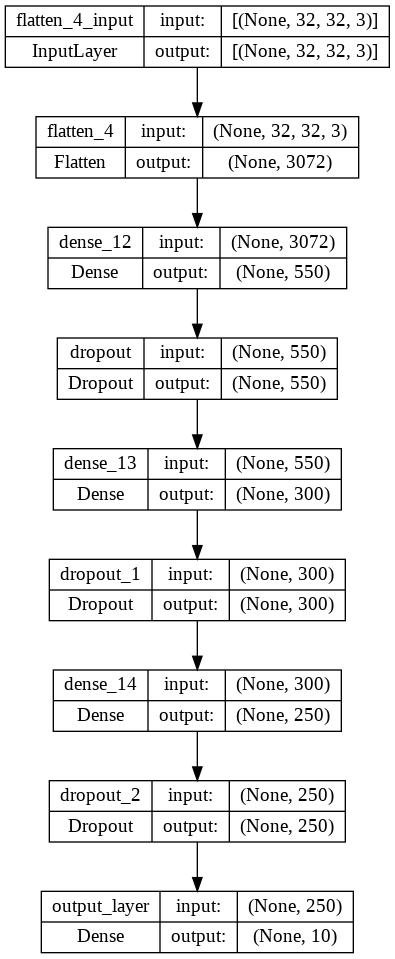

In [46]:
keras.utils.plot_model(model_5_23, "CIFAR_model.png", show_shapes=True) 

In [47]:
## Compile

model_5_23.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [48]:
## Train 
time = perf_counter()

history_5_23 = model_5_23.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("DNN_model_5_23.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ]                                                                                                           
                   )

Epoch 1/200
704/704 [==============================] - 4s 4ms/step - loss: 1.9319 - accuracy: 0.2946 - val_loss: 1.7601 - val_accuracy: 0.3658
Epoch 2/200
704/704 [==============================] - 3s 4ms/step - loss: 1.7671 - accuracy: 0.3625 - val_loss: 1.7047 - val_accuracy: 0.3878
Epoch 3/200
704/704 [==============================] - 3s 4ms/step - loss: 1.7031 - accuracy: 0.3908 - val_loss: 1.6455 - val_accuracy: 0.4098
Epoch 4/200
704/704 [==============================] - 3s 4ms/step - loss: 1.6599 - accuracy: 0.4063 - val_loss: 1.6302 - val_accuracy: 0.4182
Epoch 5/200
704/704 [==============================] - 3s 4ms/step - loss: 1.6249 - accuracy: 0.4185 - val_loss: 1.5927 - val_accuracy: 0.4234
Epoch 6/200
704/704 [==============================] - 3s 4ms/step - loss: 1.6023 - accuracy: 0.4277 - val_loss: 1.6164 - val_accuracy: 0.4228
Epoch 7/200
704/704 [==============================] - 3s 4ms/step - loss: 1.5845 - accuracy: 0.4317 - val_loss: 1.5657 - val_accuracy: 0.4326

In [49]:
time_5_23 = perf_counter() - time
print(time_5_23)

58.645278177999955


In [50]:
## Evaluate

model_5_23 = tf.keras.models.load_model("DNN_model_5_23.h5")
print(f"Test acc: {model_5_23.evaluate(x_test_norm, y_test)[1]:.3f}")

313/313 [==============================] - 1s 3ms/step - loss: 1.4211 - accuracy: 0.5006
Test acc: 0.501
